In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [47]:
import numpy as np
from scipy import integrate
from scipy import interpolate
from scipy.integrate import odeint
from nbodykit.lab import *
from nbodykit import setup_logging
from nbodykit.io import bigfile
import matplotlib.pyplot as plt

cosmo = cosmology.Planck15

seedlist_iso = []
for i in range(1991,1991+1):
    seedlist_iso.append(str(i))
    
seedlist_tides = []
for i in range(1992,1995+1):
    seedlist_tides.append(str(i))
    
kindlist_iso = ['iso', 'ppp0004', 'mmm0004']
kindlist_tides = ['iso', 'mmp003', 'ppm003']

box = 1000

lambdaz = 0.03
deltab = 0.004*3

In [48]:
data_mmp = np.loadtxt('/home/yinli/csit/analysis/Aniss/Aniss_planck2015_mmp003_z200')
data_iso_p = np.loadtxt('/home/yinli/csit/analysis/Aniss/Aniss_planck2015_ppp0004_z200')

delta_ax_mmp = interpolate.interp1d(data_mmp[:,0], data_mmp[:,1], kind="cubic")
delta_ay_mmp = interpolate.interp1d(data_mmp[:,0], data_mmp[:,2], kind="cubic")
delta_az_mmp = interpolate.interp1d(data_mmp[:,0], data_mmp[:,3], kind="cubic")

delta_ax_iso_p = interpolate.interp1d(data_iso_p[:,0], data_iso_p[:,1], kind="cubic")
delta_ay_iso_p = interpolate.interp1d(data_iso_p[:,0], data_iso_p[:,2], kind="cubic")
delta_az_iso_p = interpolate.interp1d(data_iso_p[:,0], data_iso_p[:,3], kind="cubic")

def a_ratio_mmp(z):
    scale_a = 1./(1+z)
    # replace following with function of redshift
    delta_a = np.zeros(3)
    delta_a[0] = delta_ax_mmp(scale_a)
    delta_a[1] = delta_ay_mmp(scale_a)
    delta_a[2] = delta_az_mmp(scale_a)
    return 1 + delta_a

def a_ratio_ppm(z):
    scale_a = 1./(1+z)
    # replace following with function of redshift
    delta_a = np.zeros(3)
    delta_a[0] = delta_ax_mmp(scale_a)
    delta_a[1] = delta_ay_mmp(scale_a)
    delta_a[2] = delta_az_mmp(scale_a)
    return 1 - delta_a

def a_ratio_iso_p(z):
    scale_a = 1./(1+z)
    # replace following with function of redshift
    delta_a = np.zeros(3)
    delta_a[0] = delta_ax_iso_p(scale_a)
    delta_a[1] = delta_ay_iso_p(scale_a)
    delta_a[2] = delta_az_iso_p(scale_a)
    return 1 + delta_a

def a_ratio_iso_m(z):
    scale_a = 1./(1+z)
    # replace following with function of redshift
    delta_a = np.zeros(3)
    delta_a[0] = delta_ax_iso_p(scale_a)
    delta_a[1] = delta_ay_iso_p(scale_a)
    delta_a[2] = delta_az_iso_p(scale_a)
    return 1 - delta_a

In [34]:
halo_cat_tides = {}

for seed in seedlist_tides:
    for kind in kindlist_tides:
        halo_cat_tides[seed+'_'+kind] = bigfile.BigFile(f'/mnt/sdceph/users/yinli/csit/planck2015/1000/{seed}/{kind}/ASMTH6/halos/')

In [49]:
halo_cat_iso = {}
for seed in seedlist_iso:
    for kind in kindlist_iso:
        halo_cat_iso[seed+'_'+kind] = bigfile.BigFile(f'/mnt/sdceph/users/yinli/csit/planck2015/1000/{seed}/{kind}/SU_new/halos')

In [50]:
nbin = 12
bins = np.logspace(12.5, 15, nbin)

mass_array_tides = {}
for seed in seedlist_tides:
    for kind in kindlist_tides:
        mass_array_tides[seed+'_'+kind] = halo_cat_tides[seed+'_'+kind][['Mass']].asarray()

In [51]:
mass_array_iso = {}
for seed in seedlist_iso:
    for kind in kindlist_iso:
        mass_array_iso[seed+'_'+kind] = halo_cat_iso[seed+'_'+kind][['Mass']].asarray()

IndexError: invalid string keys: ['Mass']; run keys() for valid options

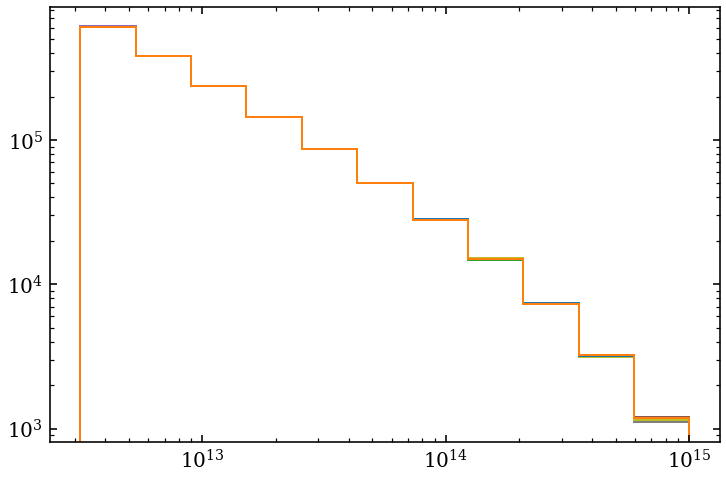

In [52]:
N_array_tides = {} #Number of halos with fixed comoving volume
for seed in seedlist_tides:
    for kind in kindlist_tides:
        N_array_tides[seed+'_'+kind] = plt.hist(mass_array_tides[seed+'_'+kind][:-1], bins,
                                                weights=np.full(mass_array_tides[seed+'_'+kind][:-1].shape, 1),
                                                histtype='step')
plt.xscale('log')
plt.yscale('log')

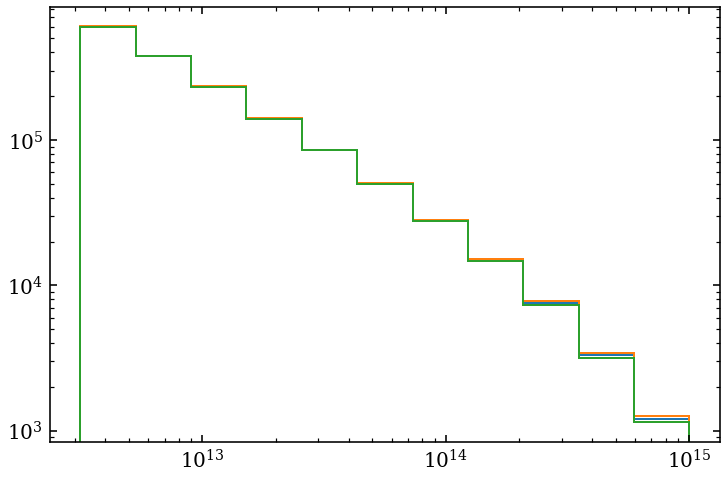

In [39]:
N_array_iso = {} #Number of halos with fixed comoving volume
for seed in seedlist_iso:
    for kind in kindlist_iso:
        N_array_iso[seed+'_'+kind] = plt.hist(mass_array_iso[seed+'_'+kind][:-1], bins,
                                          weights=np.full(mass_array_iso[seed+'_'+kind][:-1].shape, 1),
                                          histtype='step')
plt.xscale('log')
plt.yscale('log')

In [40]:
Num_halo_iso = np.zeros(nbin-1)
Num_halo_mmp = np.zeros(nbin-1)
Num_halo_ppm = np.zeros(nbin-1)

for seed in seedlist_tides:
    Num_halo_iso += N_array_tides[seed+'_'+kindlist_tides[0]][0]
    Num_halo_mmp += N_array_tides[seed+'_'+kindlist_tides[1]][0]
    Num_halo_ppm += N_array_tides[seed+'_'+kindlist_tides[2]][0]

In [41]:
Num_halo_iso_0 = np.zeros(nbin-1)
Num_halo_ppp = np.zeros(nbin-1)
Num_halo_mmm = np.zeros(nbin-1)

for seed in seedlist_iso:
    Num_halo_iso_0 += N_array_iso[seed+'_'+kindlist_iso[0]][0]
    Num_halo_ppp += N_array_iso[seed+'_'+kindlist_iso[1]][0]
    Num_halo_mmm += N_array_iso[seed+'_'+kindlist_iso[2]][0]

In [43]:
massbin = []
for i in range(1, len(bins)):
    massbin.append( np.sqrt(bins[i-1]*bins[i]) )
    
np.savetxt('./bias/massbin_1000.txt',massbin)

In [44]:
bL1 = (Num_halo_ppp - Num_halo_mmm)/(2*Num_halo_iso_0*deltab)

bL2 = (Num_halo_ppp + Num_halo_mmm - 2*Num_halo_iso_0 )/(Num_halo_iso_0*deltab*deltab)

bLs1 = (Num_halo_mmp - Num_halo_ppm)/(2*Num_halo_iso*lambdaz)
print(bLs1)

bLs2 =  (Num_halo_mmp + Num_halo_ppm - 2*Num_halo_iso )/(Num_halo_iso*lambdaz*lambdaz*3/2)
print(bLs2)

[ 0.01820029  0.01534937  0.00085772  0.0247062   0.0181511   0.02778534
  0.03770572  0.00305826 -0.03061745  0.07269517 -0.24457678]
[ 0.03247749  0.08201768 -1.72633471 -0.65265316  0.41623086 -1.4767544
 -1.20263989 -2.55781496 -0.65518827 -1.03850248  6.45903241]


In [45]:
np.savetxt('./bias/bL1_ppp0004_1000.txt',bL1)
np.savetxt('./bias/bL2_ppp0004_1000.txt',bL2)

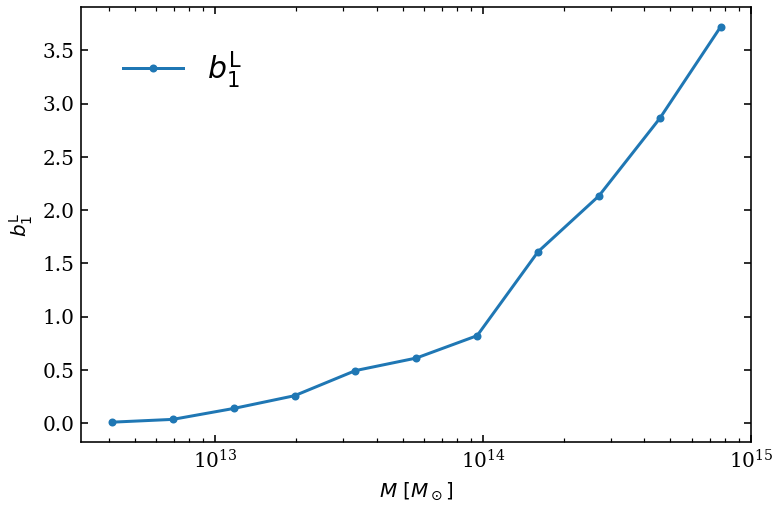

In [46]:
plt.plot(massbin, bL1, marker='.',label=r"$b^{\rm L}_{1}$" )

plt.xlabel(r"$M\ [M_\odot]$")
plt.ylabel(r"$b_{1}^{\rm L}$ ")
plt.xscale('log')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=15)
#plt.savefig('/home/yinli/csit/analysis/halos/planck2015/1000/bL1.pdf')

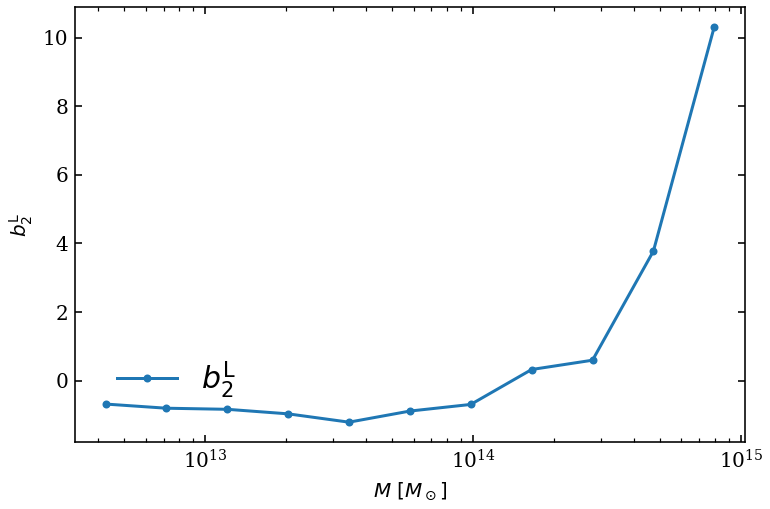

In [30]:
#plt.plot(massbin, bL2, marker='.',label=r"$b^{\rm L}_{2}$" )
plt.plot(massbin, bL2, marker='.',label=r"$b^{\rm L}_{2}$" )

plt.xlabel(r"$M\ [M_\odot]$")
plt.ylabel(r"$b_{2}^{\rm L}$ ")
plt.xscale('log')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=15)
#plt.savefig('/home/yinli/csit/analysis/halos/planck2015/1000/bL2.pdf')

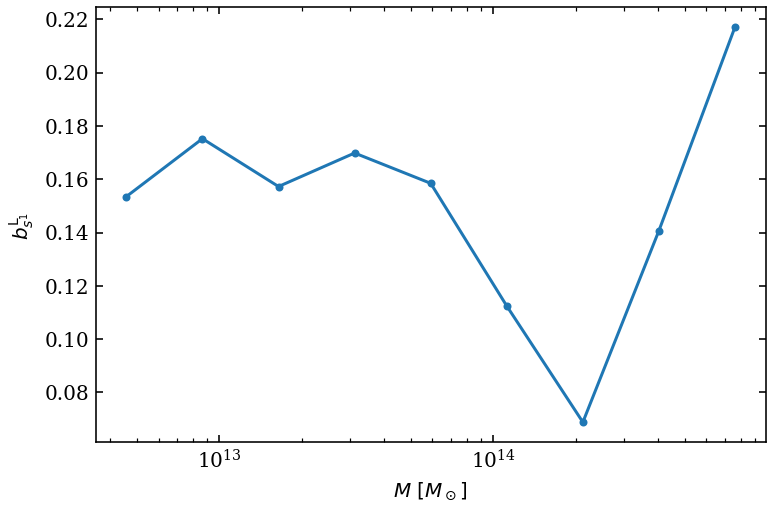

In [16]:
plt.plot(massbin, bLs1, marker='.',label=r"$b^{\rm L}_{s^1}$" )

plt.xlabel(r"$M\ [M_\odot]$")
plt.ylabel(r"$b_{s^1}^{\rm L}$ ")
plt.xscale('log')

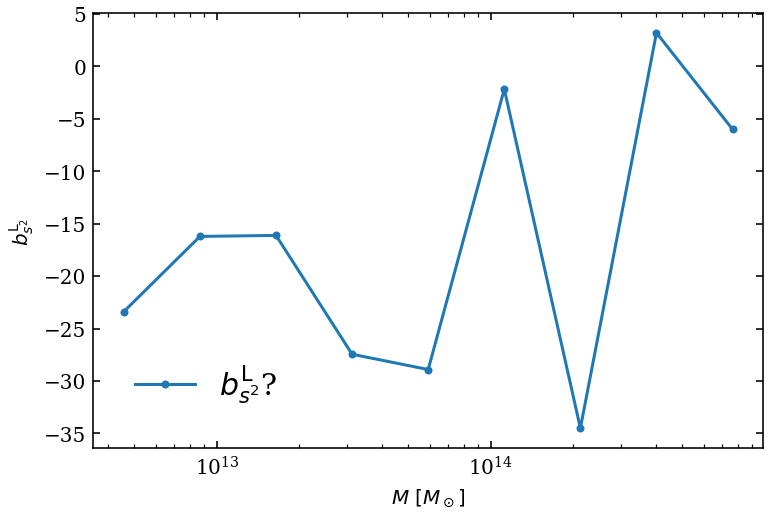

In [17]:
plt.plot(massbin, bLs2, marker='.',label=r"$b^{\rm L}_{s^2}$?" )

plt.xlabel(r"$M\ [M_\odot]$")
plt.ylabel(r"$b_{s^2}^{\rm L}$ ")
plt.xscale('log')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=15)
plt.savefig('/home/yinli/csit/analysis/halos/planck2015/1000/bLs2.pdf')

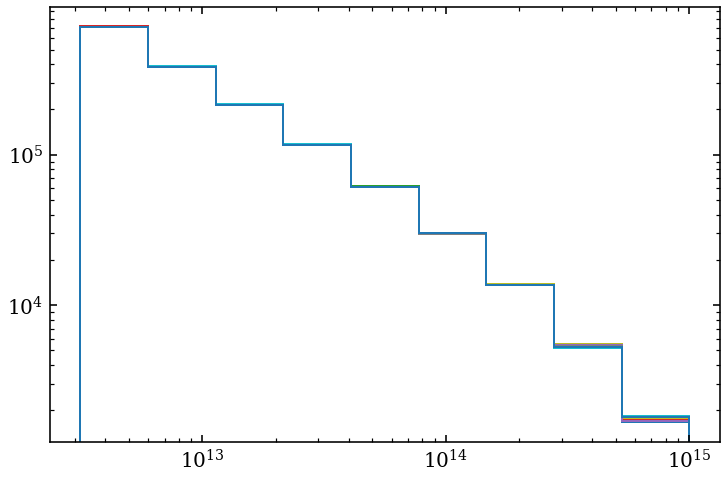

In [18]:
n_array_tides = {}  #Number density
for seed in seedlist_tides:
    n_array_tides[seed+'_iso'] = plt.hist(mass_array_tides[seed+'_iso'][:-1], bins,
                                    weights=np.full(mass_array_tides[seed+'_iso'][:-1].shape, 1),
                                    histtype='step')
    n_array_tides[seed+'_mmp'] = plt.hist(mass_array_tides[seed+'_mmp'][:-1], bins,
                                    weights=np.full(mass_array_tides[seed+'_mmp'][:-1].shape, 1./ a_ratio_mmp(0).prod()),
                                    histtype='step')
    n_array_tides[seed+'_ppm'] = plt.hist(mass_array_tides[seed+'_ppm'][:-1], bins,
                                    weights=np.full(mass_array_tides[seed+'_ppm'][:-1].shape, 1./ a_ratio_ppm(0).prod()),
                                    histtype='step')
plt.xscale('log')
plt.yscale('log')

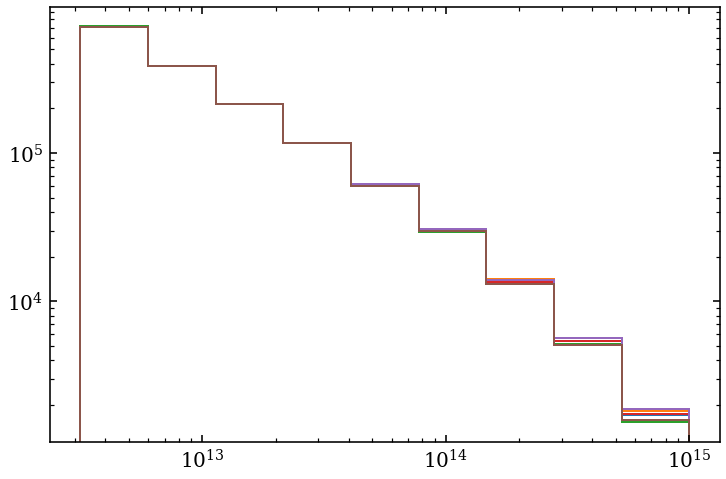

In [19]:
n_array_iso = {}  #Number density
for seed in seedlist_iso:
    n_array_iso[seed+'_iso'] = plt.hist(mass_array_iso[seed+'_iso'][:-1], bins,
                                    weights=np.full(mass_array_iso[seed+'_iso'][:-1].shape, 1),
                                    histtype='step')
    n_array_iso[seed+'_iso_p'] = plt.hist(mass_array_iso[seed+'_iso_p'][:-1], bins,
                                    weights=np.full(mass_array_iso[seed+'_iso_p'][:-1].shape, 1./ a_ratio_iso_p(0).prod()),
                                    histtype='step')
    n_array_iso[seed+'_iso_m'] = plt.hist(mass_array_iso[seed+'_iso_m'][:-1], bins,
                                    weights=np.full(mass_array_iso[seed+'_iso_m'][:-1].shape, 1./ a_ratio_iso_m(0).prod()),
                                    histtype='step')
plt.xscale('log')
plt.yscale('log')

In [20]:
n_halo_iso = np.zeros(nbin-1)
n_halo_mmp = np.zeros(nbin-1)
n_halo_ppm = np.zeros(nbin-1)

for seed in seedlist_tides:
    n_halo_iso = n_halo_iso + n_array_tides[seed+'_iso'][0]
    n_halo_mmp = n_halo_mmp + n_array_tides[seed+'_mmp'][0]
    n_halo_ppm = n_halo_ppm + n_array_tides[seed+'_ppm'][0]

In [22]:
n_halo_iso_0 = np.zeros(nbin-1)
n_halo_iso_p = np.zeros(nbin-1)
n_halo_iso_m = np.zeros(nbin-1)

for seed in seedlist_iso:
    n_halo_iso_0 = n_halo_iso_0 + n_array_iso[seed+'_iso'][0]
    n_halo_iso_p = n_halo_iso_p + n_array_iso[seed+'_iso_p'][0]
    n_halo_iso_m = n_halo_iso_m + n_array_iso[seed+'_iso_m'][0]

In [23]:
b1 = (n_halo_iso_p - n_halo_iso_m)/(2*n_halo_iso_0*deltab)

b2 = (n_halo_iso_p + n_halo_iso_m - 2*n_halo_iso_0 )/(n_halo_iso_0*deltab*deltab)

bs1 = (n_halo_mmp - n_halo_ppm)/(2*n_halo_iso*lambdaz)

bs2 =  (n_halo_mmp + n_halo_ppm - 2*n_halo_iso )/(n_halo_iso*lambdaz*lambdaz*3/2)

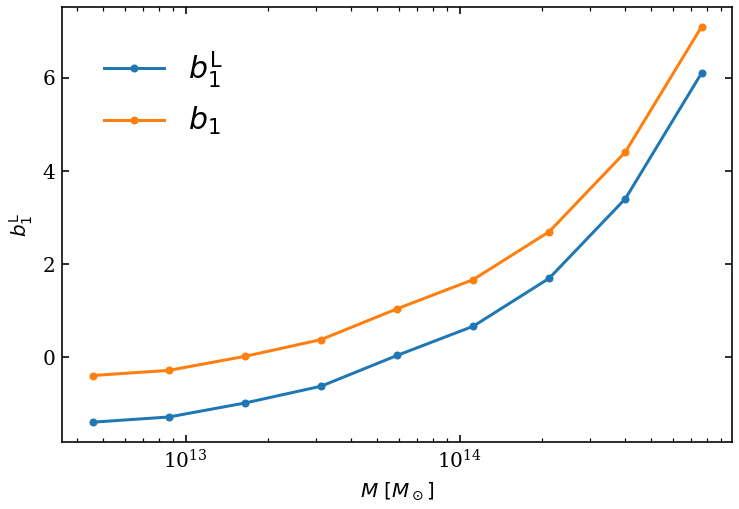

In [29]:
plt.plot(massbin, bL1, marker='.',label=r"$b^{\rm L}_{1}$" )
plt.plot(massbin, b1, marker='.',label=r"$b_{1}$" )

plt.xlabel(r"$M\ [M_\odot]$")
plt.ylabel(r"$b_{1}^{\rm L}$ ")
plt.xscale('log')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=15)
plt.savefig('/home/yinli/csit/analysis/halos/planck2015/1000/b1.pdf')

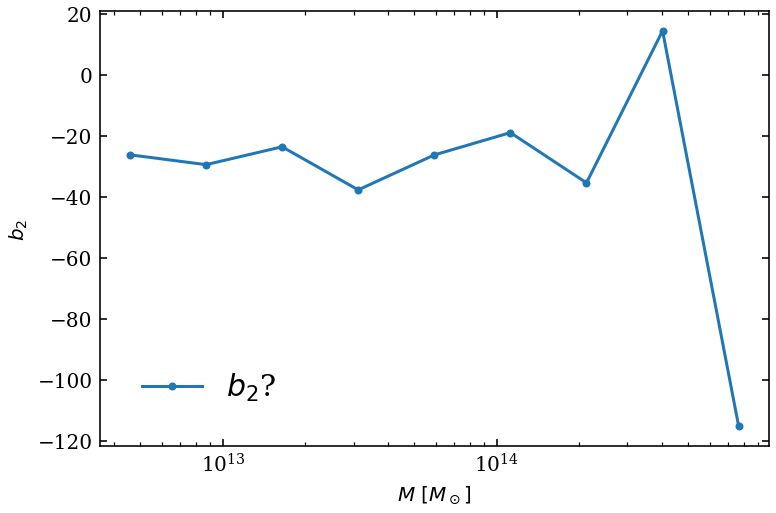

In [28]:
plt.plot(massbin, b2, marker='.',label=r"$b_{2}$?" )

plt.xlabel(r"$M\ [M_\odot]$")
plt.ylabel(r"$b_{2}$ ")
plt.xscale('log')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=15)
plt.savefig('/home/yinli/csit/analysis/halos/planck2015/1000/b2.pdf')

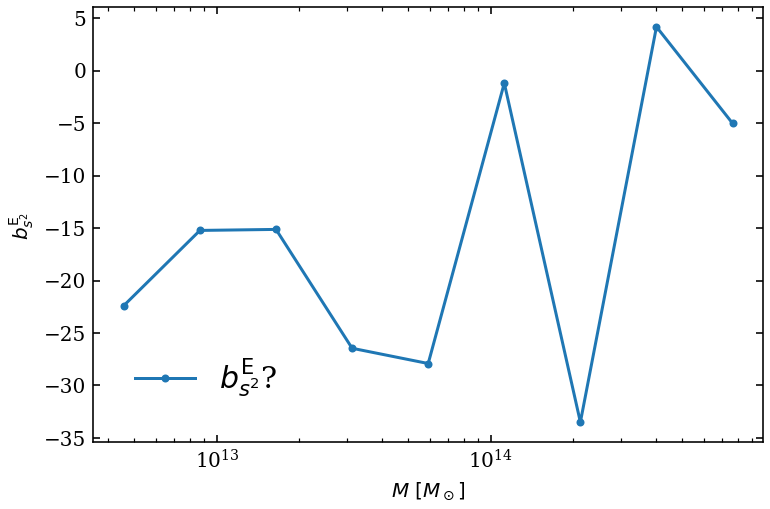

In [31]:
plt.plot(massbin, bs2, marker='.',label=r"$b^{\rm E}_{s^2}$?" )
#plt.plot(massbin, bLs2, marker='.',label=r"$b^{\rm L}_{s^2}$")
plt.xscale('log')
plt.xlabel(r"$M\ [M_\odot]$")
plt.ylabel(r"$b_{s^2}^{\rm E}$ ")
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=15)
plt.savefig('/home/yinli/csit/analysis/halos/planck2015/1000/bs2.pdf')

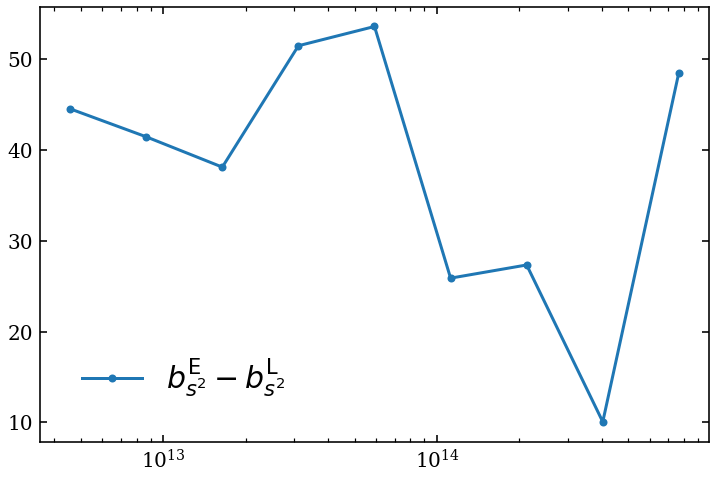

In [34]:
plt.plot(massbin, bs2-bLs2, marker='.',label=r"$b^{\rm E}_{s^2}-b^{\rm L}_{s^2}$" )
#plt.plot(massbin, bLs2, marker='.',label=r"$b^{\rm L}_{s^2}$")
plt.xscale('log')
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=15)

In [54]:
plt.hist(halo_cat['Mass'], bins=np.logspace(13, 16, 16),
         weights=np.full(halo_cat['Mass'].shape, 1 / halo_cat.attrs['BoxSize'].prod()),
         histtype='step')
plt.xscale('log')
plt.yscale('log')

KeyError: 'Mass'